In [1]:
import torch
from torchinfo import summary
from torchvision import transforms
from matplotlib import pyplot as plt

from networks_medium import Encoder, Decoder
from Autoencoders import Autoencoder
from data import CelebA

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

/home/dgalperi/anaconda3/envs/max/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


device(type='cuda', index=1)

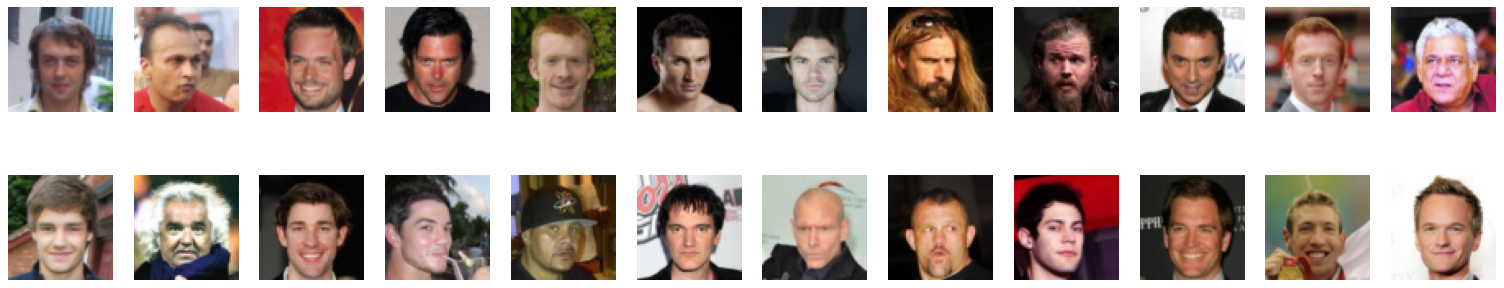

In [2]:
transform = [transforms.CenterCrop((178, 178)), transforms.Resize((64, 64))]
train_dataset = CelebA(root_dir="../", split="train", transform=transform, device=device, filter_categories=[(15, False), (20, True)])
val_dataset = CelebA(root_dir="../", split="val", transform=transform, device=device, filter_categories=[(15, False), (20, True)])

# show 2 rows of 12 images from train dataset
plt.figure(figsize=(24, 5), dpi=80)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(train_dataset[i][0].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [3]:
z_dim = 1024
in_ch = 3
out_ch = 3
base_ch = 32 #64
gap_ch = 3

encoder = Encoder(z_dim=z_dim, in_ch=in_ch, base_ch=base_ch, gap_ch=gap_ch)
decoder = Decoder(z_dim=z_dim, out_ch=out_ch, base_ch=base_ch, gap_ch=gap_ch)
encoder._build_fc_if_needed(16, 16)
decoder._build_fc_if_needed(16, 16)

In [4]:
autoencoder = Autoencoder(encoder, decoder).to(device)

autoencoder.reconstruction_loss = torch.nn.MSELoss()

In [5]:
bs = 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)

In [6]:
# If you want to load a model from checkpoint, uncomment the following lines:

# conformal_autoencoder.encoder._build_fc_if_needed(16,16)
# conformal_autoencoder.decoder._build_fc_if_needed(16,16)
# conformal_autoencoder.load_model_from_checkpoint("models/path.pth")

In [7]:
# if you want to load optimizer and scheduler state from checkpoint, uncomment the following lines (and include optimizer and scheduler in train_model call):

# optimizer = torch.optim.Adam(conformal_autoencoder.parameters(), lr=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
# optimizer.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_optimizer.pth"))
# scheduler.load_state_dict(torch.load("models/celeba_autoencoder_v3_3_scheduler.pth"))


In [8]:
epochs = 400
optimizer, scheduler = autoencoder.train_model(train_loader,
                                                         val_loader,
                                                         has_label=True,
                                                         epochs=epochs,
                                                         batch_size=bs,
                                                         learning_rate=1e-3,
                                                         val_every=10,
                                                         scheduler_kwargs={"step_size":20, "gamma":0.85}
                                                         )

Epoch [10/400], Validation Loss: 0.00303027


Epoch [20/400], Validation Loss: 0.00234718


Epoch [30/400], Validation Loss: 0.00198723


Epoch [40/400], Validation Loss: 0.00163633


Epoch [50/400], Validation Loss: 0.00155743


Epoch [60/400], Validation Loss: 0.00141262


Epoch [70/400], Validation Loss: 0.00136693


Epoch [80/400], Validation Loss: 0.00131726


Epoch [90/400], Validation Loss: 0.00122271


Epoch [100/400], Loss: 0.00123084


Epoch [100/400], Validation Loss: 0.00119877


Epoch [110/400], Validation Loss: 0.00119753


Epoch [120/400], Validation Loss: 0.00114997


Epoch [130/400], Validation Loss: 0.00113976


Epoch [140/400], Validation Loss: 0.00111718


Epoch [150/400], Validation Loss: 0.00110195


Epoch [160/400], Validation Loss: 0.00110898


Epoch [170/400], Validation Loss: 0.00110019


Epoch [180/400], Validation Loss: 0.00110641


Epoch [190/400], Validation Loss: 0.00108540


Epoch [200/400], Loss: 0.00107604


Epoch [200/400], Validation Loss: 0.00107597


Epoch [210/400], Validation Loss: 0.00105953


Epoch [220/400], Validation Loss: 0.00105188


Epoch [230/400], Validation Loss: 0.00104375


Epoch [240/400], Validation Loss: 0.00104762


Epoch [250/400], Validation Loss: 0.00104237


Epoch [260/400], Validation Loss: 0.00103767


Epoch [270/400], Validation Loss: 0.00103695


Epoch [280/400], Validation Loss: 0.00103138


Epoch [290/400], Validation Loss: 0.00102988


Epoch [300/400], Loss: 0.00102732


Epoch [300/400], Validation Loss: 0.00102806


Epoch [310/400], Validation Loss: 0.00102374


Epoch [320/400], Validation Loss: 0.00102904


Epoch [330/400], Validation Loss: 0.00101864


Epoch [340/400], Validation Loss: 0.00102013


Epoch [350/400], Validation Loss: 0.00101831


Epoch [360/400], Validation Loss: 0.00101580


Epoch [370/400], Validation Loss: 0.00101317


Epoch [380/400], Validation Loss: 0.00101468


Epoch [390/400], Validation Loss: 0.00101114


Epoch [400/400], Loss: 0.00100747


Epoch [400/400], Validation Loss: 0.00101220


In [9]:
autoencoder.save_checkpoint("models/celeba_autoencoder_v1_2.pth") # z_dim = 1024, MSELoss, base_ch=32, gap_ch=3

Checkpoint saved to models/celeba_autoencoder_v1_2.pth at epoch 401


In [13]:
torch.save(optimizer.state_dict(), "models/celeba_autoencoder_v1_2_optimizer.pth")
torch.save(scheduler.state_dict(), "models/celeba_autoencoder_v1_2_scheduler.pth")

In [11]:
#get current learning rate
for param_group in optimizer.param_groups:
    current_lr = param_group['lr']
    break
print(f"Current learning rate: {current_lr}")

Current learning rate: 3.875953108451434e-05


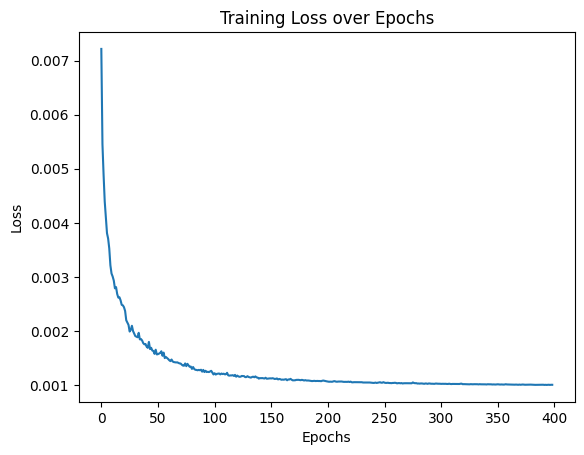

In [15]:
plt.plot(autoencoder.metrics_list["reconstruction_loss"][1:], label="Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

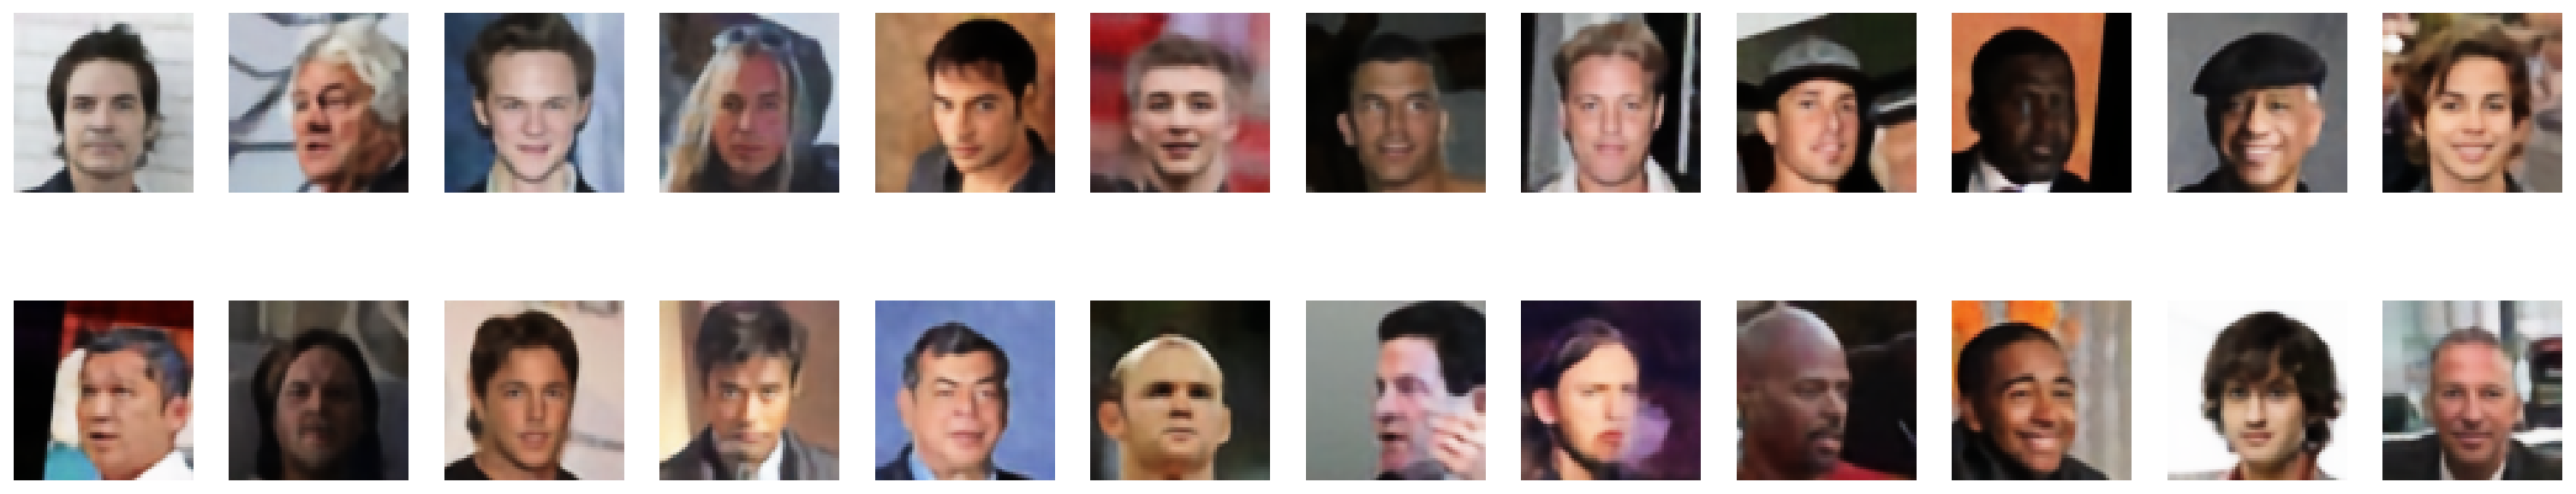

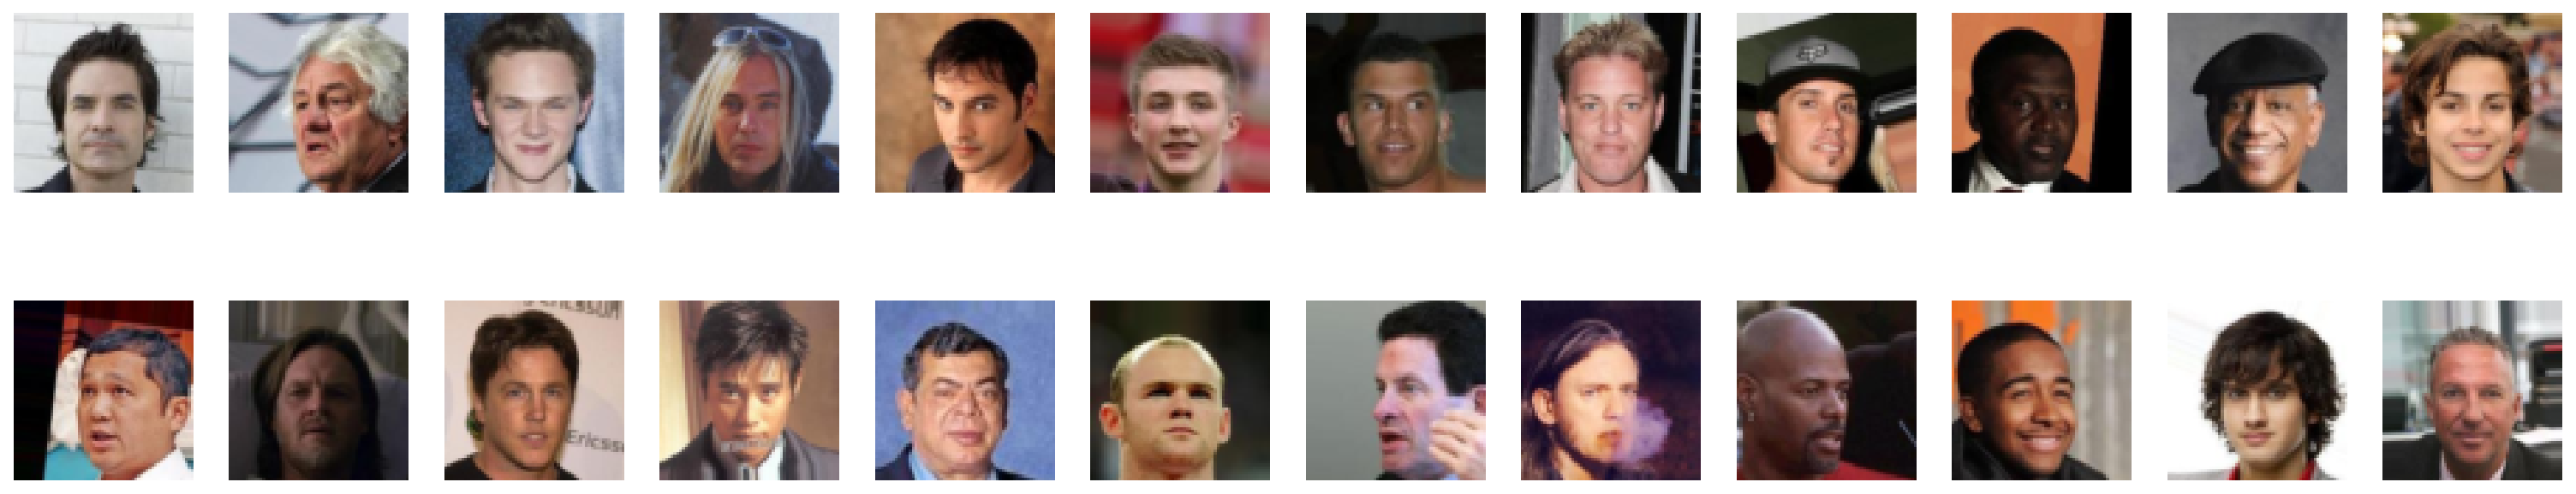

In [16]:
samples = autoencoder.forward(val_dataset.get_sample(24, seed=32)[0].to(device))
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(samples[i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()
plt.figure(figsize=(24, 5), dpi=160)
for i in range(24):
    plt.subplot(2, 12, i + 1)
    plt.imshow(val_dataset.get_sample(24, seed=32)[0][i].permute(1, 2, 0).detach().cpu())
    plt.axis('off')
plt.show()

In [16]:
from metrics_copy import evaluate_conformality

evaluate_conformality(autoencoder, val_dataset.get_sample(50, seed=42)[0].to(device), chunk_size=64)

tensor([0., -0., 0., -0., -0., -0., 0., -0., 0., 0., 0., 0., 0., 0., 0., -0., 0., -0., 0., 0., 0., -0., -0., 0.,
        -0., -0., -0., 0., -0., 0., 0., 0., -0., -0., -0., 0., 0., 0., -0., 0., -0., 0., 0., 0., 0., -0., -0., -0.,
        0., 0.], device='cuda:1', dtype=torch.float64)
tensor([1.4742e-133,  0.0000e+00, 9.0257e-157, 1.0478e-131,  0.0000e+00,
         4.9385e-28,  0.0000e+00, 5.6437e-138, 3.0904e-144, 7.6384e-119,
         0.0000e+00,  1.5784e-87, 1.3014e-142,  6.6490e-89,  0.0000e+00,
         1.0198e-57, 2.6135e-157, 9.9889e-105,  0.0000e+00,  0.0000e+00,
        2.3902e-142,  0.0000e+00,  0.0000e+00, 7.9178e-100,  0.0000e+00,
        8.0818e-125,  3.0098e-94, 1.5428e-121,  1.1801e-94,  0.0000e+00,
         0.0000e+00,  4.8844e-74,  1.4817e-51,  5.6591e-97, 2.1287e-160,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  3.4490e-98,  8.1723e-91,
        3.1005e-126,  9.2204e-84,  0.0000e+00, 4.2632e-158,

{'Reconstruction Error': 0.001174300443381071,
 'Diagonal Uniformity (gini)': 0.07031165808439255,
 'Conformal Factor Mean': 0.5275973677635193,
 'Conformal Factor Std': 0.1438203901052475,
 'Conformal Factor Std (normalized)': 0.27259495854377747,
 'Conformal Factor Estimate Error': 0.007484806701540947,
 'Conformal Factor Estimate Error (normalized)': 0.014186585322022438,
 'Off-diagonal Mean': 0.01960938051342964,
 'Off-diagonal Mean (normalized)': 0.03830714523792267,
 'Off-diagonal Norm': 25.93906021118164,
 'Off-diagonal Norm (normalized)': 50.682987213134766,
 'Conformality Mean': 0.01965881511569023,
 'Conformality Mean (normalized)': 0.03840259090065956,
 'Conformality Norm': 26.031734466552734,
 'Conformality Norm (normalized)': 50.8609504699707,
 'Determinant Estimation Error': 9.87700503381423e-30,
 'Determinant Estimation Error (normalized)': 8.285432344269433e-23,
 'Determinant Estimation from Estimate Error': 8.08831251980328e-31,
 'Determinant Estimation from Estimate E